In [163]:
import h5py
import numpy as np
filename =  r"20190915_01325_binned.h5"
file = h5py.File(filename, 'r')
data = file['2D_Data']['Fixed_Spectra1'][:]
xcoords = file['0D_Data']['Scan X'][:]
ycoords = file['0D_Data']['Scan Y'][:]

In [209]:
print(data.shape)
flat_data = data.reshape(data.shape[2], -1)[np.sort(np.random.randint(0, 91*91, 1000))]

(232, 259, 8281)


In [210]:
flat_data.shape

(1000, 60088)

In [289]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.8)
transformed_data = pca.fit_transform(flat_data)

In [290]:
# for component in pca.components_:
#     plt.imshow(component.reshape(259,232), origin='lower', cmap='gray')
#     plt.show()

In [291]:
pca.n_components_

9

In [292]:
import numpy
from ripser import ripser
from persim import plot_diagrams
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans

In [293]:
diagrams = ripser(transformed_data, 0)['dgms']

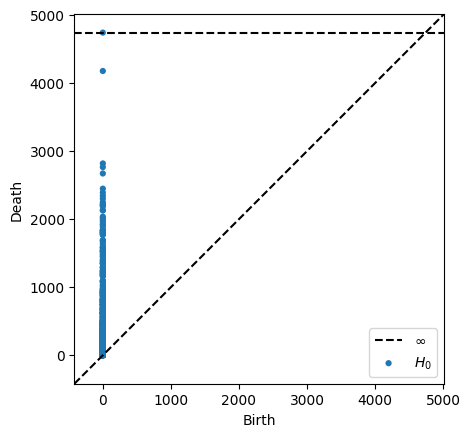

In [294]:
plot_diagrams(diagrams, show=True)
plt.show()

/Users/matthewstaab/Documents/ALS_Fellowship/auto_ARPES/venv/lib/python3.9/site-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


[18  7  6  4  3]
k: 18 with silhouette score 0.5377180367138371
k: 7 with silhouette score 0.5313493921099129
k: 6 with silhouette score 0.5569761826064017
k: 4 with silhouette score 0.6122563462067637
k: 3 with silhouette score 0.6507641585130335 <--- Best


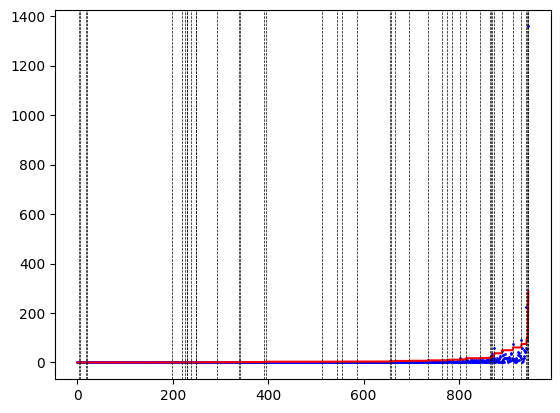

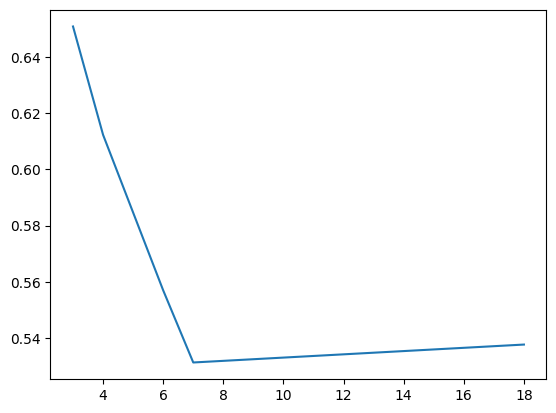

In [299]:
deaths = diagrams[0][:,1]
death_derivs = np.diff(deaths, append=deaths[-1])
# three_sigma = 2*np.std(np.diff(deaths))
def detect_persistant_features(deaths):
    death_derivs = np.diff(deaths, append=deaths[-1]*2)
    mask = np.zeros(len(death_derivs), dtype=bool)
    rolling_cutoff = np.zeros(len(death_derivs))
    for i, death_deriv in enumerate(death_derivs):
        if i<3:#i < 0.95*len(death_derivs):
            rolling_cutoff[i] = 0
            continue
        cutoff = np.quantile(death_derivs[:i], 0.999)
        rolling_cutoff[i] = cutoff
        if death_deriv > rolling_cutoff[i-1]:
            mask[i] = True
    return np.arange(len(death_derivs))[mask], rolling_cutoff

# three_sigma = np.quantile(death_derivs, 0.997)
# steep_indices = np.argwhere(death_derivs > three_sigma)

steep_indices, rolling_cutoff = detect_persistant_features(deaths)
possible_cluster_values = len(deaths)-steep_indices+1
max_n_clusters = 20
possible_cluster_values = possible_cluster_values[possible_cluster_values < max_n_clusters]
print(possible_cluster_values)


from sklearn.metrics import silhouette_samples, silhouette_score
list_of_cluster_labels = []
list_of_k = []
for k in possible_cluster_values:
    kmeans = KMeans(n_clusters=k, n_init=10).fit(transformed_data)
    list_of_cluster_labels.append(kmeans.labels_)
    list_of_k.append(k)

silhouette_scores = []
for labels in list_of_cluster_labels:
    silhouette_scores.append(silhouette_score(transformed_data, labels))
for k, sil in zip(list_of_k, silhouette_scores):
    if sil == np.max(silhouette_scores):
        print(f"k: {k} with silhouette score {sil} <--- Best")
    else:
        print(f"k: {k} with silhouette score {sil}")

plt.scatter(np.arange(len(deaths)), death_derivs, color='blue', s=1)
# plt.axhline(three_sigma)
plt.plot(rolling_cutoff, color='red')
for i in steep_indices:
    plt.axvline(i, color='k', linestyle='--', linewidth=0.5)
plt.show()
plt.plot(list_of_k, silhouette_scores)
plt.show()